In [1]:
%matplotlib notebook

# <center>Segmentation tutorial</center>
## Hugues Talbot
## CentraleSupélec 
### Feb. 2021

### Image segmentation is the task of labeling the pixels of objects of interest in an image.

In this tutorial, we will see how to segment objects from a background. We use the coins image from skimage.data. This image shows several coins outlined against a darker background. The segmentation of the coins cannot be done directly from the histogram of grey values, because the background shares enough grey levels with the coins that a thresholding segmentation is not sufficient.

In [2]:
import numpy as np
from skimage import data
from skimage.exposure import histogram
coins = data.coins()
hist, hist_centers = histogram(coins)

### 0- Basic image manipulation in python

In [3]:
import matplotlib.pyplot as plt
def imageview(image,cmap='gray'):
    plt.figure()
    plt.imshow(image,cmap=cmap)
    plt.show()

<IPython.core.display.Javascript object>


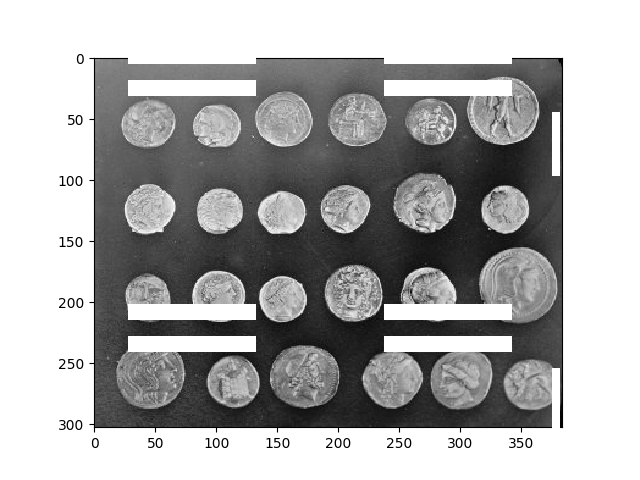

In [4]:
imageview(coins)

### show the histogram

<IPython.core.display.Javascript object>


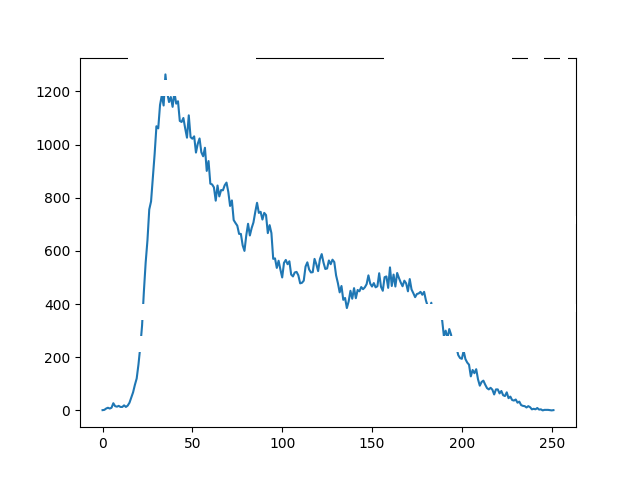

In [5]:
## your code here...
plt.figure()
plt.plot(hist)
plt.show()

## 1- Pixel-based segmentation

Simply thresholding the image leads either to missing significant parts of the coins, or to merging parts of the background with the coins. This is due to the inhomogeneous lighting of the image

<IPython.core.display.Javascript object>


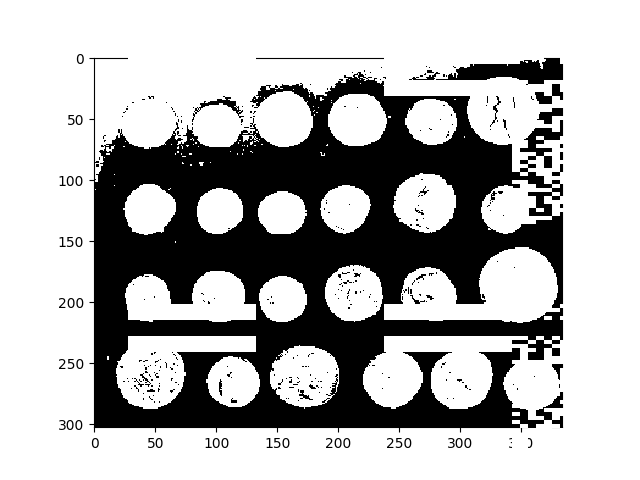

In [6]:
## show a threshold of the image at 100 and 150
## 1- make an empty image with the same dimension as the input
bin1 = None ### YOUR CODE HERE
## 2- select the pixels greater than 100 or 150 
bin1[None] = 1 ### YOUR CODE HERE
imageview(bin1)

In [ ]:
## try the automated segmentation methods: Otsu etc
from skimage.filters import try_all_threshold

img = data.page()

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
## try with the coin image

## Otsu's method

Otsu’s method (https://en.wikipedia.org/wiki/Otsu’s_method) calculates an “optimal” threshold (marked by a red line in the histogram below) by maximizing the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.

In [ ]:
from skimage.filters import threshold_otsu


image = data.camera()
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

In [ ]:
## YOUR CODE HERE try on the coin image

## 2- Edge-based segmentation

Let us first try to detect edges that enclose the coins. For edge detection, we use the Canny detector of skimage.feature.canny

In [18]:
from skimage.feature import canny
edges = canny(coins/255.)

<IPython.core.display.Javascript object>


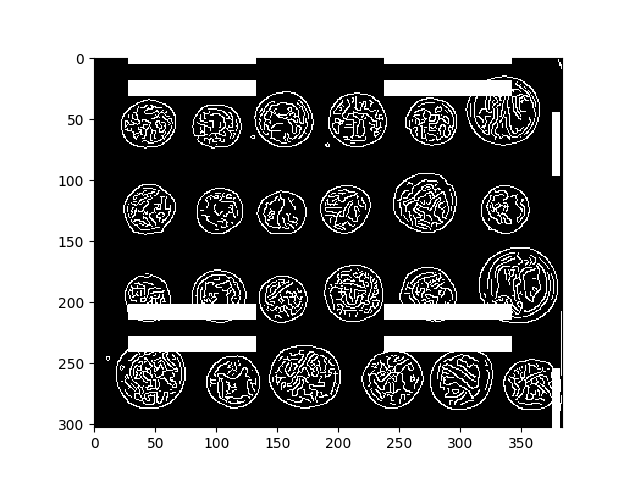

In [19]:
## show the result
imageview(edges)

As the background is very smooth, almost all edges are found at the boundary of the coins, or inside the coins.

Now that we have contours that delineate the outer boundary of the coins, we fill the inner part of the coins using the ndi.binary_fill_holes function, which uses mathematical morphology to fill the holes.

In [20]:
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(edges)

Most coins are well segmented out of the background. Small objects from the background can be easily removed using the ndi.label function to remove objects smaller than a small threshold.

In [21]:
label_objects, nb_labels = ndi.label(fill_coins)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]

<IPython.core.display.Javascript object>


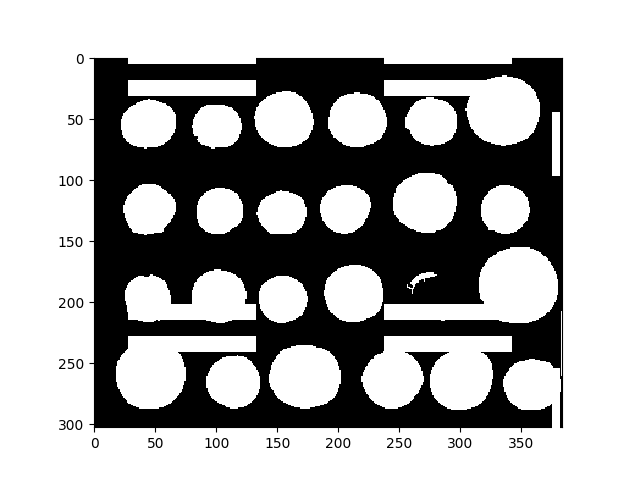

In [22]:
## show the result
imageview(coins_cleaned)

However, the segmentation is not very satisfying, since one of the coins has not been segmented correctly at all. The reason is that the contour that we got from the Canny detector was not completely closed, therefore the filling function did not fill the inner part of the coin.

Therefore, this segmentation method is not very robust: if we miss a single pixel of the contour of the object, we will not be able to fill it. Of course, we could try to dilate the contours in order to close them. However, it is preferable to try a more robust method.

## 3- Region-based segmentation

Let us first determine markers of the coins and the background. These markers are pixels that we can label unambiguously as either object or background. Here, the markers are found at the two extreme parts of the histogram of grey values:

In [35]:
markers = np.zeros_like(coins)
## select the area of the image below a low value (e.g 30) 
markers[None] = 1 ## YOUR CODE HERE
## select the area of the image with a high value (e.g 150)
markers[None] = 2 ## YOUR CODE HERE

We will use these markers in a _watershed segmentation_. The name watershed comes from an analogy with hydrology. The watershed transform floods an image of elevation starting from markers, in order to determine the catchment basins of these markers. Watershed lines separate these catchment basins, and correspond to the desired segmentation.

The choice of the elevation map is critical for good segmentation. Here, the amplitude of the gradient provides a good elevation map. We use the Sobel operator for computing the amplitude of the gradient:

In [23]:
from skimage.filters import sobel
elevation_map = sobel(coins)

<IPython.core.display.Javascript object>


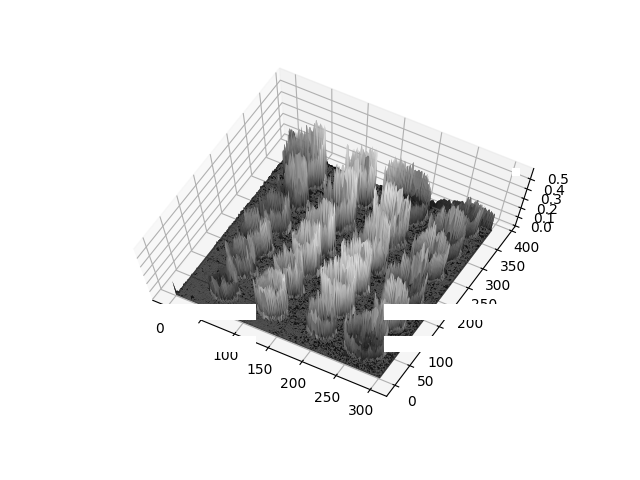

In [33]:
## do a 3D plot of the elevation map
## see here: https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xx, yy = np.mgrid[0:elevation_map.shape[0], 0:elevation_map.shape[1]]
ax.plot_surface(xx,yy,elevation_map, rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)
plt.show()

From the 3-D surface plot shown above, we see that high barriers effectively separate the coins from the background.

<IPython.core.display.Javascript object>


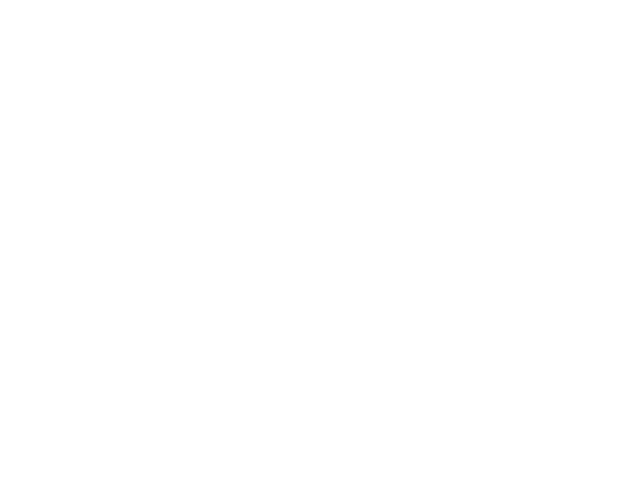

<IPython.core.display.Javascript object>


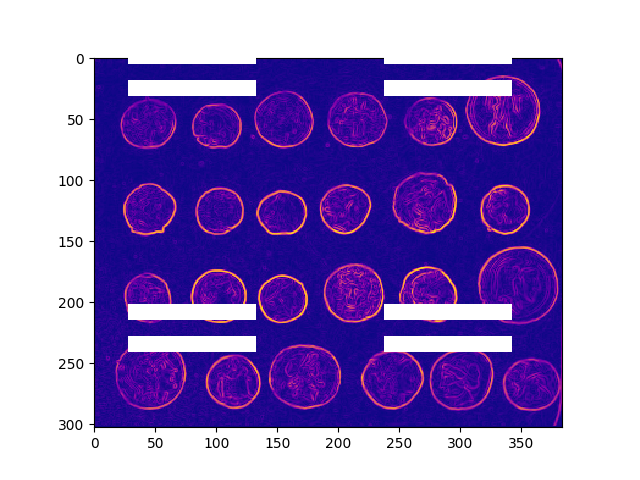

In [29]:
## show the 2D elevation map (the magnitude of the gradient)
plt.figure()
imageview(elevation_map,cmap="plasma")
plt.show()

In [30]:
elevation_map.shape

(303, 384)

Let us now compute the watershed transform:


In [36]:
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)

With this method, the result is satisfying for all coins. Even if the markers for the background were not well distributed, the barriers in the elevation map were high enough for these markers to flood the entire background.

We remove a few small holes with mathematical morphology:

In [37]:
segmentation = ndi.binary_fill_holes(segmentation - 1)

We can now label all the coins one by one using ndi.label:

In [38]:
labeled_coins, _ = ndi.label(segmentation)

<IPython.core.display.Javascript object>


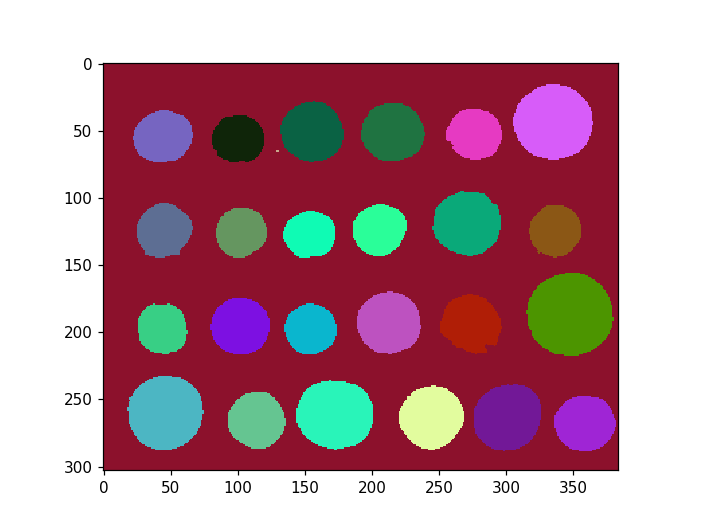

In [62]:
## show the resulting two images
import matplotlib
randcmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))
imageview(labeled_coins,cmap=randcmap)

## 3.1- Other segmentation methods

Try with random walker and graph cuts.

<IPython.core.display.Javascript object>


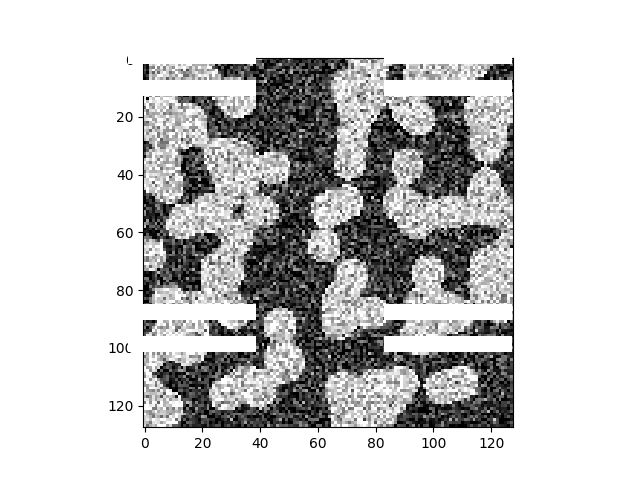

<IPython.core.display.Javascript object>


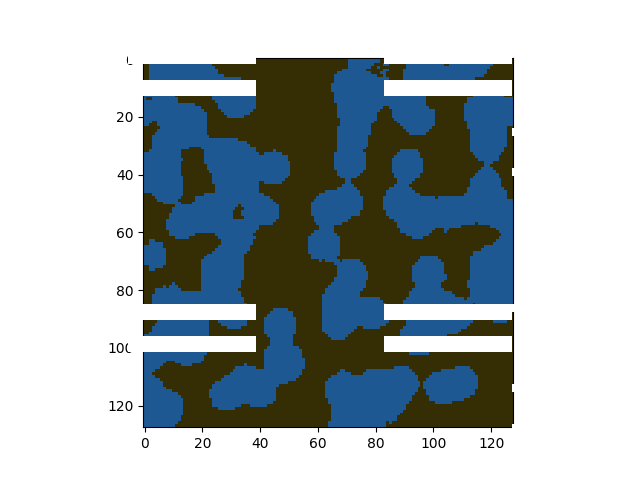

<IPython.core.display.Javascript object>


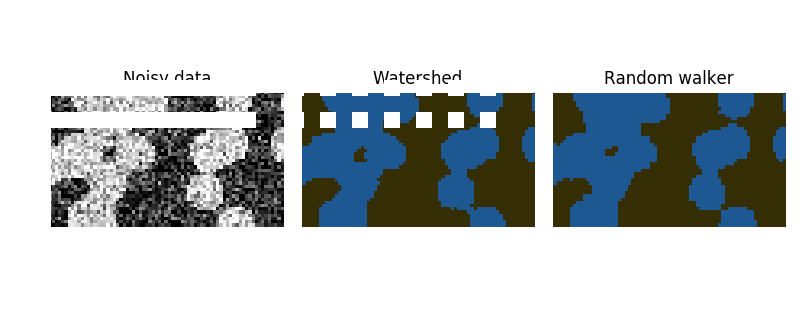

In [60]:
from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

# Generate noisy synthetic data
data = skimage.img_as_float(binary_blobs(length=128, seed=1))
sigma = 0.35
data += np.random.normal(loc=0, scale=sigma, size=data.shape)
data = rescale_intensity(data, in_range=(-sigma, 1 + sigma),
                         out_range=(-1, 1))



## a- show data
imageview(data)
## b- propose markers
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.95] = 1
markers[data > 0.95] = 2
## c- test watershed
elevation_map = sobel(data)
labelsWS = watershed(elevation_map, markers)
imageview(labelsWS,cmap=randcmap)
## d- test random walker
# Run random walker algorithm
labelsRW = random_walker(data, markers, beta=10, mode='bf')


##
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray', interpolation='nearest')
ax1.axis('off')
ax1.set_title('Noisy data')
ax2.imshow(labelsWS, cmap=randcmap, interpolation='nearest')
ax2.axis('off')
ax2.set_title('Watershed')
ax3.imshow(labelsRW, cmap=randcmap, interpolation='nearest')
ax3.axis('off')
ax3.set_title('Random walker')

fig.tight_layout()
plt.show()

Arguably, the RW result has a smoother contour.

### 3.2- A more challenging example

Here is a much more challenging, noisy example of a material with weak contours, try various ideas to segment the grains of the material.

<IPython.core.display.Javascript object>


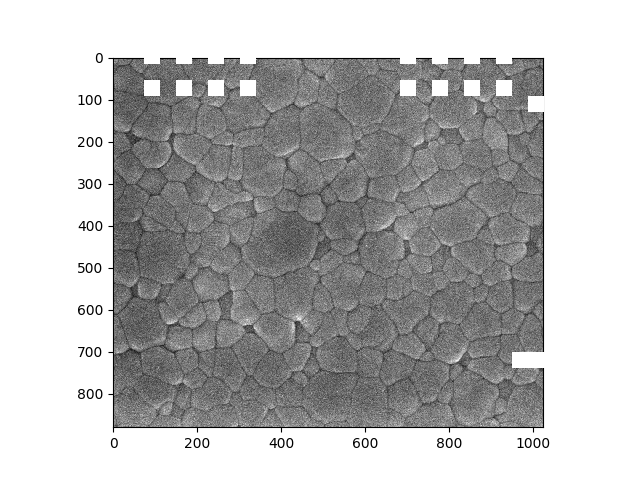

In [17]:
from skimage import io
import urllib
(fn,header)=urllib.request.urlretrieve("https://github.com/emmanuelle/image-processing-tutorials/raw/master/images/grains_crop.png")
im = io.imread(fn)
imageview(im)

In [15]:
fn

'/var/folders/2r/p7h2n4ds2y7b91vpthl6htvr0000gn/T/tmpcrch_2sy'

In [13]:
header